In [1]:
!pip install transformers

In [2]:
import json
import torch
import matplotlib
import pandas as pd
import random
import os

from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from tqdm import tqdm
from json import loads, dumps
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from sklearn.manifold import TSNE
from IPython.display import display, HTML
from google.colab import files

# Activation steering with data-generated vectors

In [3]:
# token = input("Enter HF token: ")
token = os.getenv('HF_TOKEN')

In [4]:
system_prompt = "You are a helpful, honest and concise assistant."

# Process data for generating steering vectors

In [5]:
def prompt_to_tokens(tokenizer, system_prompt, instruction, model_output):
    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
    dialog_content = B_SYS + system_prompt + E_SYS + instruction.strip()
    dialog_tokens = tokenizer.encode(
        f"{B_INST} {dialog_content.strip()} {E_INST} {model_output.strip()}"
    )
    return torch.tensor(dialog_tokens).unsqueeze(0)

In [6]:
class ComparisonDataset(Dataset):
    def __init__(self, data, system_prompt):
        self.data = data
        self.system_prompt = system_prompt
        self.tokenizer = AutoTokenizer.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf", use_auth_token=token
        )
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        question = item["question"]
        pos_answer = item["answer_stereotype"]
        neg_answer = item["answer_anti_stereotype"]
        pos_tokens = prompt_to_tokens(
            self.tokenizer, self.system_prompt, question, pos_answer
        )
        neg_tokens = prompt_to_tokens(
            self.tokenizer, self.system_prompt, question, neg_answer
        )
        return pos_tokens, neg_tokens

In [9]:
## load text data
filename = 'gender_stereotypes_augmented_A_B.json'
with open(filename, "r") as f:
    data_gender = json.load(f)

filename = 'stereotype_data_A_B_subset.json'
with open(filename, "r") as f:
    data_stereoset = json.load(f)

In [11]:
## tokenize data
gender_dataset = ComparisonDataset(data_gender, system_prompt)
race_dataset = ComparisonDataset(data_stereoset['race'], system_prompt)
religion_dataset = ComparisonDataset(data_stereoset['religion'], system_prompt)

total_samples = len(race_dataset) + len(gender_dataset) + len(religion_dataset)
print(f"Using {total_samples} samples")

Using 450 samples


# Generate steering vector using llama-2-7b-chat

- Saves steering vectors locally
- We wrap transformer in a helper class to be able to manipulate and access internal state

## Helper functions

- Helper functions to augment residual stream output at particular token positions.
- We can use `kwargs['position_ids']` to figure out what position we are at and add steering vector accordingly.

In [12]:
def add_vector_after_position(matrix, vector, position_ids, after=None):
    after_id = after
    if after_id is None:
        after_id = position_ids.min().item() - 1
    mask = position_ids > after_id
    mask = mask.unsqueeze(-1)
    matrix += mask.float() * vector
    return matrix


def find_subtensor_position(tensor, sub_tensor):
    n, m = tensor.size(0), sub_tensor.size(0)
    if m > n:
        return -1
    for i in range(n - m + 1):
        if torch.equal(tensor[i : i + m], sub_tensor):
            return i
    return -1


def find_instruction_end_postion(tokens, end_str):
    end_pos = find_subtensor_position(tokens, end_str)
    return end_pos + len(end_str) - 1

## llama-2-7b-chat wrapper

(Code to enable manipulation and saving of internal activations)

In [13]:
class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.activations = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        self.activations = output[0]
        return output


class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm, tokenizer):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm
        self.tokenizer = tokenizer

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_out_unembedded = None
        self.intermediate_resid_unembedded = None
        self.mlp_out_unembedded = None
        self.block_out_unembedded = None

        self.activations = None
        self.add_activations = None
        self.after_position = None

        self.save_internal_decodings = False

        self.calc_dot_product_with = None
        self.dot_products = []

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        self.activations = output[0]
        if self.calc_dot_product_with is not None:
            last_token_activations = self.activations[0, -1, :]
            decoded_activations = self.unembed_matrix(self.norm(last_token_activations))
            top_token_id = torch.topk(decoded_activations, 1)[1][0]
            top_token = self.tokenizer.decode(top_token_id)
            dot_product = torch.dot(last_token_activations, self.calc_dot_product_with)
            self.dot_products.append((top_token, dot_product.cpu().item()))
        if self.add_activations is not None:
            augmented_output = add_vector_after_position(
                matrix=output[0],
                vector=self.add_activations,
                position_ids=kwargs["position_ids"],
                after=self.after_position,
            )
            output = (augmented_output + self.add_activations,) + output[1:]

        if not self.save_internal_decodings:
            return output

        # Whole block unembedded
        self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))

        # Self-attention unembedded
        attn_output = self.block.self_attn.activations
        self.attn_out_unembedded = self.unembed_matrix(self.norm(attn_output))

        # Intermediate residual unembedded
        attn_output += args[0]
        self.intermediate_resid_unembedded = self.unembed_matrix(self.norm(attn_output))

        # MLP unembedded
        mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
        self.mlp_out_unembedded = self.unembed_matrix(self.norm(mlp_output))

        return output

    def add(self, activations):
        self.add_activations = activations

    def reset(self):
        self.add_activations = None
        self.activations = None
        self.block.self_attn.activations = None
        self.after_position = None
        self.calc_dot_product_with = None
        self.dot_products = []


class Llama7BChatHelper:
    def __init__(self, token, system_prompt):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.system_prompt = system_prompt
        self.tokenizer = AutoTokenizer.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf", use_auth_token=token
        )
        self.model = AutoModelForCausalLM.from_pretrained(
            "meta-llama/Llama-2-7b-chat-hf", use_auth_token=token
        ).to(self.device)
        self.END_STR = torch.tensor(self.tokenizer.encode("[/INST]")[1:]).to(
            self.device
        )
        for i, layer in enumerate(self.model.model.layers):
            self.model.model.layers[i] = BlockOutputWrapper(
                layer, self.model.lm_head, self.model.model.norm, self.tokenizer
            )

    def set_save_internal_decodings(self, value):
        for layer in self.model.model.layers:
            layer.save_internal_decodings = value

    def set_after_positions(self, pos):
        for layer in self.model.model.layers:
            layer.after_position = pos

    def prompt_to_tokens(self, instruction):
        B_INST, E_INST = "[INST]", "[/INST]"
        B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
        dialog_content = B_SYS + self.system_prompt + E_SYS + instruction.strip()
        dialog_tokens = self.tokenizer.encode(
            f"{B_INST} {dialog_content.strip()} {E_INST}"
        )
        return torch.tensor(dialog_tokens).unsqueeze(0)

    def generate_text(self, prompt, max_new_tokens=50):
        tokens = self.prompt_to_tokens(prompt).to(self.device)
        return self.generate(tokens, max_new_tokens=max_new_tokens)

    def generate(self, tokens, max_new_tokens=50):
        instr_pos = find_instruction_end_postion(tokens[0], self.END_STR)
        self.set_after_positions(instr_pos)
        generated = self.model.generate(
            inputs=tokens, max_new_tokens=max_new_tokens, top_k=1
        )
        return self.tokenizer.batch_decode(generated)[0]

    def get_logits(self, tokens):
        with torch.no_grad():
            logits = self.model(tokens).logits
            return logits

    def get_last_activations(self, layer):
        return self.model.model.layers[layer].activations

    def set_add_activations(self, layer, activations):
        self.model.model.layers[layer].add(activations)

    def set_calc_dot_product_with(self, layer, vector):
        self.model.model.layers[layer].calc_dot_product_with = vector

    def get_dot_products(self, layer):
        return self.model.model.layers[layer].dot_products

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()

    def print_decoded_activations(self, decoded_activations, label, topk=10):
        data = self.get_activation_data(decoded_activations, topk)[0]
        print(label, data)

    def decode_all_layers(
        self,
        tokens,
        topk=10,
        print_attn_mech=True,
        print_intermediate_res=True,
        print_mlp=True,
        print_block=True,
    ):
        tokens = tokens.to(self.device)
        self.get_logits(tokens)
        for i, layer in enumerate(self.model.model.layers):
            print(f"Layer {i}: Decoded intermediate outputs")
            if print_attn_mech:
                self.print_decoded_activations(
                    layer.attn_out_unembedded, "Attention mechanism", topk=topk
                )
            if print_intermediate_res:
                self.print_decoded_activations(
                    layer.intermediate_resid_unembedded,
                    "Intermediate residual stream",
                    topk=topk,
                )
            if print_mlp:
                self.print_decoded_activations(
                    layer.mlp_out_unembedded, "MLP output", topk=topk
                )
            if print_block:
                self.print_decoded_activations(
                    layer.block_output_unembedded, "Block output", topk=topk
                )

    def plot_decoded_activations_for_layer(self, layer_number, tokens, topk=10):
        tokens = tokens.to(self.device)
        self.get_logits(tokens)
        layer = self.model.model.layers[layer_number]

        data = {}
        data["Attention mechanism"] = self.get_activation_data(
            layer.attn_out_unembedded, topk
        )[1]
        data["Intermediate residual stream"] = self.get_activation_data(
            layer.intermediate_resid_unembedded, topk
        )[1]
        data["MLP output"] = self.get_activation_data(layer.mlp_out_unembedded, topk)[1]
        data["Block output"] = self.get_activation_data(
            layer.block_output_unembedded, topk
        )[1]

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
        fig.suptitle(f"Layer {layer_number}: Decoded Intermediate Outputs", fontsize=21)

        for ax, (mechanism, values) in zip(axes.flatten(), data.items()):
            tokens, scores = zip(*values)
            ax.barh(tokens, scores, color="skyblue")
            ax.set_title(mechanism)
            ax.set_xlabel("Value")
            ax.set_ylabel("Token")

            # Set scientific notation for x-axis labels when numbers are small
            ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci", scilimits=(0, 0), axis="x")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def get_activation_data(self, decoded_activations, topk=10):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, topk)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        return list(zip(tokens, probs_percent)), list(zip(tokens, values.tolist()))

## Plotting functions

For plotting projected activations at different layers and seeing how they cluster

In [19]:
def save_activation_projection_tsne(
    activations1,
    activations2,
    fname,
    title,
    label1="Stereotype Examples",
    label2="Anti-Stereotype Examples",
):
    """
    activations1: n_samples x vector dim tensor
    activations2: n_samples x vector dim tensor

    projects to n_samples x 2 dim tensor using t-SNE (over the full dataset of both activations 1 and 2) and saves visualization.
    Colors projected activations1 as blue and projected activations2 as red.
    """
    plt.clf()
    activations = torch.cat([activations1, activations2], dim=0)
    activations_np = activations.cpu().numpy()

    # t-SNE transformation
    tsne = TSNE(n_components=2)
    projected_activations = tsne.fit_transform(activations_np)

    # Splitting back into activations1 and activations2
    activations1_projected = projected_activations[: activations1.shape[0]]
    activations2_projected = projected_activations[activations1.shape[0] :]

    # Visualization
    for x, y in activations1_projected:
        plt.scatter(x, y, color="#B80D48", marker="o", alpha=0.4)

    for x, y in activations2_projected:
        plt.scatter(x, y, color="#F29724", marker="o", alpha=0.4)

    # Adding the legend
    scatter1 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#B80D48",
        markersize=10,
        label=label1,
    )
    scatter2 = plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="#F29724",
        markersize=10,
        label=label2,
    )

    plt.legend(handles=[scatter1, scatter2])
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.savefig(fname)


def plot_all_activations(layers, directory):
    path = f"clustering/{directory}"
    if not os.path.exists(path):
        os.makedirs(path)
    for layer in layers:
        pos = torch.load(f"{directory}/positive_layer_{layer}.pt")
        neg = torch.load(f"{directory}/negative_layer_{layer}.pt")
        save_activation_projection_tsne(
            pos,
            neg,
            f"clustering/{directory}/activations_layer_{layer}.png",
            f"t-SNE projected activations layer {layer} ({directory})",
        )

## Get and save activations

In [15]:
def generate_and_save_steering_vectors(
    model, dataset, directory, start_layer=0, end_layer=32, token_idx=-2
):
    layers = list(range(start_layer, end_layer + 1))
    positive_activations = dict([(layer, []) for layer in layers])
    negative_activations = dict([(layer, []) for layer in layers])
    model.set_save_internal_decodings(False)
    model.reset_all()
    for p_tokens, n_tokens in tqdm(dataset, desc="Processing prompts"):
        p_tokens = p_tokens.to(model.device)
        n_tokens = n_tokens.to(model.device)
        model.reset_all()
        model.get_logits(p_tokens)
        for layer in layers:
            p_activations = model.get_last_activations(layer)
            p_activations = p_activations[0, token_idx, :].detach().cpu()
            positive_activations[layer].append(p_activations)
        model.reset_all()
        model.get_logits(n_tokens)
        for layer in layers:
            n_activations = model.get_last_activations(layer)
            n_activations = n_activations[0, token_idx, :].detach().cpu()
            negative_activations[layer].append(n_activations)
    for layer in layers:
        positive = torch.stack(positive_activations[layer])
        negative = torch.stack(negative_activations[layer])
        vec = (positive - negative).mean(dim=0)

        if not os.path.exists(directory):
            os.mkdir(directory)
        torch.save(vec, f"{directory}/vec_layer_{layer}.pt")
        torch.save(positive, f"{directory}/positive_layer_{layer}.pt")
        torch.save(
            negative,
            f"{directory}/negative_layer_{layer}.pt",
        )

In [16]:
model = Llama7BChatHelper(token, system_prompt)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [17]:
start_layer = 5
end_layer = 31

direc = 'gender_rlhf'
os.makedirs(direc)
generate_and_save_steering_vectors(model, gender_dataset, direc, start_layer=start_layer, end_layer=end_layer)

Processing prompts: 100%|██████████| 72/72 [00:21<00:00,  3.40it/s]


In [18]:
!zip -r /content/gender_rlhf_vecs.zip /content/gender_rlhf

  adding: content/gender_rlhf/ (stored 0%)
  adding: content/gender_rlhf/vec_layer_17.pt (deflated 10%)
  adding: content/gender_rlhf/vec_layer_11.pt (deflated 10%)
  adding: content/gender_rlhf/vec_layer_16.pt (deflated 11%)
  adding: content/gender_rlhf/vec_layer_27.pt (deflated 11%)
  adding: content/gender_rlhf/vec_layer_25.pt (deflated 11%)
  adding: content/gender_rlhf/negative_layer_8.pt (deflated 8%)
  adding: content/gender_rlhf/vec_layer_14.pt (deflated 10%)
  adding: content/gender_rlhf/vec_layer_18.pt (deflated 11%)
  adding: content/gender_rlhf/negative_layer_29.pt (deflated 8%)
  adding: content/gender_rlhf/negative_layer_21.pt (deflated 8%)
  adding: content/gender_rlhf/positive_layer_16.pt (deflated 7%)
  adding: content/gender_rlhf/positive_layer_18.pt (deflated 7%)
  adding: content/gender_rlhf/positive_layer_26.pt (deflated 8%)
  adding: content/gender_rlhf/negative_layer_16.pt (deflated 7%)
  adding: content/gender_rlhf/negative_layer_31.pt (deflated 8%)
  adding: c

In [ ]:
files.download('gender_rlhf_vecs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
direc = 'race_rlhf'
os.makedirs(direc)
generate_and_save_steering_vectors(model, race_dataset, direc, start_layer=start_layer, end_layer=end_layer)

Processing prompts: 100%|██████████| 300/300 [00:58<00:00,  5.16it/s]


In [ ]:
!zip -r /content/race_rlhf_vecs.zip /content/race_rlhf

  adding: content/race_rlhf_v2/ (stored 0%)
  adding: content/race_rlhf_v2/negative_layer_11.pt (deflated 8%)
  adding: content/race_rlhf_v2/vec_layer_18.pt (deflated 10%)
  adding: content/race_rlhf_v2/vec_layer_28.pt (deflated 11%)
  adding: content/race_rlhf_v2/negative_layer_25.pt (deflated 8%)
  adding: content/race_rlhf_v2/vec_layer_8.pt (deflated 11%)
  adding: content/race_rlhf_v2/vec_layer_16.pt (deflated 11%)
  adding: content/race_rlhf_v2/positive_layer_26.pt (deflated 8%)
  adding: content/race_rlhf_v2/positive_layer_22.pt (deflated 8%)
  adding: content/race_rlhf_v2/negative_layer_10.pt (deflated 8%)
  adding: content/race_rlhf_v2/negative_layer_7.pt (deflated 8%)
  adding: content/race_rlhf_v2/positive_layer_21.pt (deflated 7%)
  adding: content/race_rlhf_v2/vec_layer_15.pt (deflated 10%)
  adding: content/race_rlhf_v2/negative_layer_22.pt (deflated 8%)
  adding: content/race_rlhf_v2/negative_layer_21.pt (deflated 8%)
  adding: content/race_rlhf_v2/positive_layer_15.pt (d

In [ ]:
files.download('race_rlhf_vecs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
direc = 'religion_rlhf'
os.makedirs(direc)
generate_and_save_steering_vectors(model, religion_dataset, direc, start_layer=start_layer, end_layer=end_layer)

Processing prompts: 100%|██████████| 78/78 [00:14<00:00,  5.24it/s]


In [ ]:
!zip -r /content/religion_rlhf_vecs.zip /content/religion_rlhf

  adding: content/religion_rlhf_v2/ (stored 0%)
  adding: content/religion_rlhf_v2/negative_layer_11.pt (deflated 8%)
  adding: content/religion_rlhf_v2/vec_layer_18.pt (deflated 10%)
  adding: content/religion_rlhf_v2/vec_layer_28.pt (deflated 11%)
  adding: content/religion_rlhf_v2/negative_layer_25.pt (deflated 8%)
  adding: content/religion_rlhf_v2/vec_layer_8.pt (deflated 11%)
  adding: content/religion_rlhf_v2/vec_layer_16.pt (deflated 10%)
  adding: content/religion_rlhf_v2/positive_layer_26.pt (deflated 8%)
  adding: content/religion_rlhf_v2/positive_layer_22.pt (deflated 8%)
  adding: content/religion_rlhf_v2/negative_layer_10.pt (deflated 8%)
  adding: content/religion_rlhf_v2/negative_layer_7.pt (deflated 8%)
  adding: content/religion_rlhf_v2/positive_layer_21.pt (deflated 8%)
  adding: content/religion_rlhf_v2/vec_layer_15.pt (deflated 10%)
  adding: content/religion_rlhf_v2/negative_layer_22.pt (deflated 8%)
  adding: content/religion_rlhf_v2/negative_layer_21.pt (deflate

In [ ]:
files.download('religion_rlhf_vecs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize steering vectors

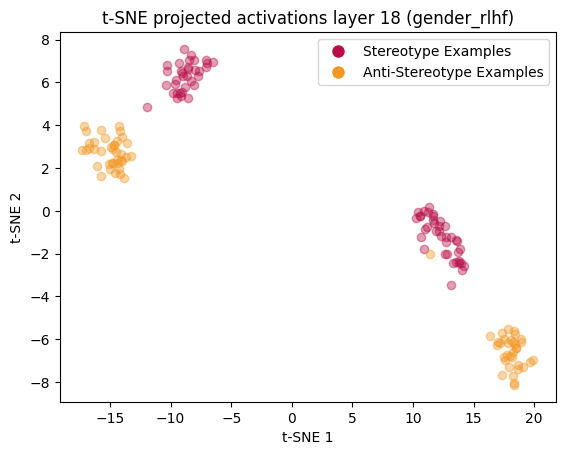

In [20]:
plot_all_activations([10,12,14,16,18], 'gender_rlhf')

In [23]:
# plot_all_activations([10,12,14,16,18], 'race_rlhf')

In [24]:
# plot_all_activations([10,12,14,16,18], 'religion_rlhf')